In [105]:
# Montando o Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
# Setando o Diretório
import os
workdir_path = '/content/drive/My Drive/airbnb/rj'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

In [107]:
!ls

calendar.csv  listings.csv


In [222]:
# Instalando as Bibliotecas
#!pip install implicit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
#import implicit 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


#Import machine learning
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost

#Data Understanding

In [109]:
#Loading and checking listings dataframe
df = pd.read_csv('listings.csv')
df.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17878,https://www.airbnb.com/rooms/17878,20210928134526,2021-09-28,"Very Nice 2Br in Copacabana w. balcony, fast WiFi",Discounts for long term stays. <br />- Large b...,This is the one of the bests spots in Rio. Bec...,https://a0.muscache.com/pictures/65320518/3069...,68997,https://www.airbnb.com/users/show/68997,Matthias,2010-01-08,"Rio de Janeiro, State of Rio de Janeiro, Brazil",I am a journalist/writer. Lived in NYC for ...,within an hour,100%,98%,f,https://a0.muscache.com/im/pictures/user/67b13...,https://a0.muscache.com/im/pictures/user/67b13...,Copacabana,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Rio de Janeiro, Brazil",Copacabana,NaN,-22.96599,-43.17940,Entire condominium (condo),Entire home/apt,5,NaN,1 bath,2.0,2.0,"[""Hangers"", ""Dishes and silverware"", ""Iron"", ""...",$350.00,4,180,4,4,1125,1125,4.0,1125.0,NaN,t,16,46,69,314,2021-09-28,265,12,0,2011-03-30,2021-05-21,4.68,4.78,4.63,4.82,4.9,4.76,4.65,NaN,t,1,1,0,0,2.07
1,24480,https://www.airbnb.com/rooms/24480,20210928134526,2021-09-29,"Nice and cozy near Ipanema Beach, w/ home office","My studio is located in the best of Ipanema, t...","The beach, the lagoon, Ipanema is a great loca...",https://a0.muscache.com/pictures/11955612/b28e...,99249,https://www.airbnb.com/users/show/99249,Goya,2010-03-26,"Rio de Janeiro, Rio de Janeiro, Brazil",Welcome to Rio!\nI am a human being fighting f...,within a day,50%,NaN,f,https://a0.muscache.com/im/pictures/user/6b404...,https://a0.muscache.com/im/pictures/user/6b404...,Ipanema,0.0,0.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Rio de Janeiro, Brazil",Ipanema,NaN,-22.98405,-43.20189,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Clothing storage: wardrobe"", ""Dining table"",...",$297.00,3,90,3,3,90,90,3.0,90.0,NaN,t,0,0,0,30,2021-09-29,85,0,0,2013-08-20,2017-04-22,4.73,4.83,4.78,4.90,4.9,4.97,4.58,NaN,f,1,1,0,0,0.86
2,25026,https://www.airbnb.com/rooms/25026,20210928134526,2021-09-28,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",Copacabana is a lively neighborhood and the ap...,https://a0.muscache.com/pictures/3003965/68ebb...,102840,https://www.airbnb.com/users/show/102840,Viviane,2010-04-03,"Rio de Janeiro, State of Rio de Janeiro, Brazil","Hi guys, We're a lovely team of 3 people:\r\n\...",within a day,50%,36%,f,https://a0.muscache.com/im/pictures/user/9e204...,https://a0.muscache.com/im/pictures/user/9e204...,Copacabana,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Rio de Janeiro, Brazil",Copacabana,NaN,-22.97735,-43.19105,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,2.0,"[""Kitchen"", ""Cable TV"", ""Han

In [110]:
#SHape of listings dataframe
df.shape

(23414, 74)

In [111]:
#Column names of listings dataframe
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [112]:
#Info columns of listings dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23414 entries, 0 to 23413
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            23414 non-null  int64  
 1   listing_url                                   23414 non-null  object 
 2   scrape_id                                     23414 non-null  int64  
 3   last_scraped                                  23414 non-null  object 
 4   name                                          23393 non-null  object 
 5   description                                   22162 non-null  object 
 6   neighborhood_overview                         12739 non-null  object 
 7   picture_url                                   23414 non-null  object 
 8   host_id                                       23414 non-null  int64  
 9   host_url                                      23414 non-null 

In [113]:
#Loading and checking Calendar dataframe
df_calendar = pd.read_csv('calendar.csv')
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,1151855,2021-09-29,f,$500.00,$500.00,1.0,1125.0
1,858748,2021-09-28,t,$200.00,$200.00,5.0,1125.0
2,858748,2021-09-29,t,$200.00,$200.00,5.0,1125.0
3,858748,2021-09-30,t,$200.00,$200.00,5.0,1125.0
4,858748,2021-10-01,t,$130.00,$130.00,5.0,1125.0


In [114]:
#Info columns of calendar dataframe
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8545976 entries, 0 to 8545975
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 456.4+ MB


##Cleaning Calendar data

In [115]:
#Checking null values
df_calendar.isnull().sum()

listing_id           0
date                 0
available            0
price              194
adjusted_price     194
minimum_nights    1113
maximum_nights    1113
dtype: int64

In [116]:
#Dropping NAs of price column
df_calendar.dropna(subset=['price'], inplace=True)

In [117]:
#turning price into float 
def remove_symbol(price):
    """remove the symbols ['$', ','] in price"""
    if type(price) is str:
        return re.sub("[\$,]",'',price)
    return price

df_calendar['price'] = df_calendar.price.apply(remove_symbol)
df_calendar['price'] = df_calendar['price'].astype(float)

In [118]:
df_calendar.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,listing_id,price,minimum_nights,maximum_nights
count,8545782.00000,8545782.00000,8544669.00000,8544669.00000
mean,26411665.29202,756.13911,5.27997,92480.36006
std,16651320.87527,8147.49886,19.61013,14035221.61440
min,17878.00000,0.00000,1.00000,1.00000
25%,12424008.00000,160.00000,2.00000,90.00000
50%,26188185.00000,292.00000,3.00000,1125.00000
75%,41939482.00000,600.00000,4.00000,1125.00000
max,52494052.00000,2171050.00000,730.00000,2147483647.00000


Checking for outliers according to Tukey Test

In [119]:
def tukey_test(df, column_name):
  Q1 = df[column_name].quantile(0.25)
  Q3 = df[column_name].quantile(0.75)

  IQR = Q3 - Q1

  Max = Q3 + 1.5*IQR
  Min = Q1 - 1.5*IQR
  
  return print('For {} column, the min value should be {} and the max value should be {}'.format(column_name, Min, Max))

In [120]:
tukey_test(df=df_calendar, column_name='maximum_nights')

For maximum_nights column, the min value should be -1462.5 and the max value should be 2677.5


In [121]:
tukey_test(df=df_calendar, column_name='price')

For price column, the min value should be -500.0 and the max value should be 1260.0


In [122]:
tukey_test(df=df_calendar, column_name='minimum_nights')

For minimum_nights column, the min value should be -1.0 and the max value should be 7.0


In [123]:
#Removing outliers from df_calendar
df_calendar = df_calendar.query('maximum_nights < 2677')
df_calendar = df_calendar.query('price < 1260')
df_calendar = df_calendar.query('minimum_nights < 7')

In [124]:
#Removing price = 0 from the DataSet
df_calendar = df_calendar[df_calendar['price'] != 0]

In [125]:
df_calendar.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,listing_id,price,minimum_nights,maximum_nights
count,6819196.00000,6819196.00000,6819196.00000,6819196.00000
mean,27493408.69180,334.82595,2.47450,769.34392
std,16609194.52674,257.11720,1.28072,493.37192
min,17878.00000,39.00000,1.00000,1.00000
25%,13149546.00000,150.00000,1.00000,90.00000
50%,30171524.00000,250.00000,2.00000,1125.00000
75%,42230659.00000,437.00000,3.00000,1125.00000
max,52490411.00000,1259.00000,6.00000,2000.00000


In [126]:
#Extracting year and month from date column
df_calendar['year'] = pd.DatetimeIndex(df_calendar['date']).year
df_calendar['month'] = pd.DatetimeIndex(df_calendar['date']).month

In [127]:
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,year,month
0,1151855,2021-09-29,f,500.0,$500.00,1.0,1125.0,2021,9
1,858748,2021-09-28,t,200.0,$200.00,5.0,1125.0,2021,9
2,858748,2021-09-29,t,200.0,$200.00,5.0,1125.0,2021,9
3,858748,2021-09-30,t,200.0,$200.00,5.0,1125.0,2021,9
4,858748,2021-10-01,t,130.0,$130.00,5.0,1125.0,2021,10


#EDA cleaned calendar Dataset

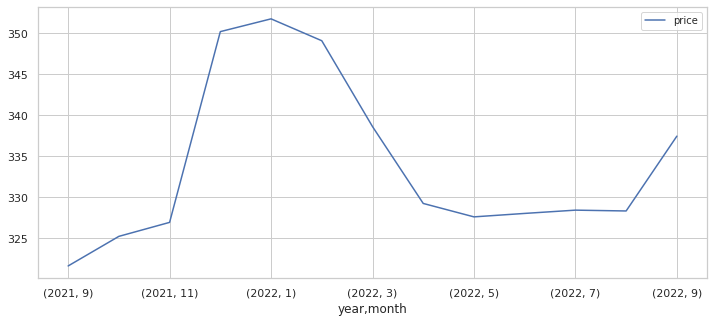

In [128]:
#Plotting the average price by month/year
df_calendar.groupby(['year','month'])['price'].mean().plot(figsize=(12,5));
plt.legend((['price']), loc= 1,  prop={'size': 10})

In [129]:
#Minimum and maximum prices in the period
print('The minimum price is {} and the maximum is {}.'.format(df_calendar.price.min(), df_calendar.price.max()))

The minimum price is 39.0 and the maximum is 1259.0.


In [130]:
dict_av = {'t':1, 'f':0}

In [131]:
df_calendar['count_available'] = df_calendar['available'].map(dict_av)

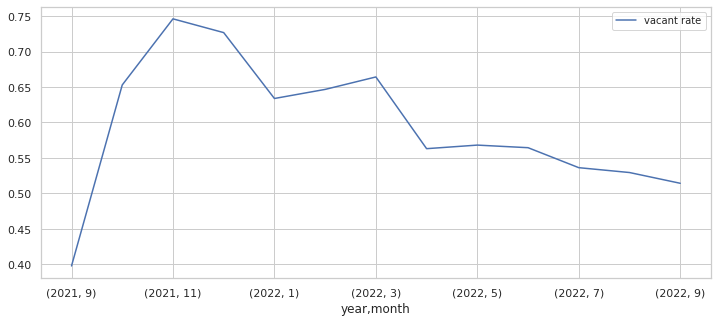

In [132]:
#Plotting the average vacant rate by month/year
df_calendar.groupby(['year','month'])['count_available'].mean().plot(figsize=(12,5));
plt.legend((['vacant rate']), loc= 1,  prop={'size': 10})

#Cleaning and understanding listings data

In [133]:
df.head(2)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17878,https://www.airbnb.com/rooms/17878,20210928134526,2021-09-28,"Very Nice 2Br in Copacabana w. balcony, fast WiFi",Discounts for long term stays. <br />- Large b...,This is the one of the bests spots in Rio. Bec...,https://a0.muscache.com/pictures/65320518/3069...,68997,https://www.airbnb.com/users/show/68997,Matthias,2010-01-08,"Rio de Janeiro, State of Rio de Janeiro, Brazil",I am a journalist/writer. Lived in NYC for ...,within an hour,100%,98%,f,https://a0.muscache.com/im/pictures/user/67b13...,https://a0.muscache.com/im/pictures/user/67b13...,Copacabana,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Rio de Janeiro, Brazil",Copacabana,NaN,-22.96599,-43.17940,Entire condominium (condo),Entire home/apt,5,NaN,1 bath,2.0,2.0,"[""Hangers"", ""Dishes and silverware"", ""Iron"", ""...",$350.00,4,180,4,4,1125,1125,4.0,1125.0,NaN,t,16,46,69,314,2021-09-28,265,12,0,2011-03-30,2021-05-21,4.68,4.78,4.63,4.82,4.9,4.76,4.65,NaN,t,1,1,0,0,2.07
1,24480,https://www.airbnb.com/rooms/24480,20210928134526,2021-09-29,"Nice and cozy near Ipanema Beach, w/ home office","My studio is located in the best of Ipanema, t...","The beach, the lagoon, Ipanema is a great loca...",https://a0.muscache.com/pictures/11955612/b28e...,99249,https://www.airbnb.com/users/show/99249,Goya,2010-03-26,"Rio de Janeiro, Rio de Janeiro, Brazil",Welcome to Rio!\nI am a human being fighting f...,within a day,50%,NaN,f,https://a0.muscache.com/im/pictures/user/6b404...,https://a0.muscache.com/im/pictures/user/6b404...,Ipanema,0.0,0.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Rio de Janeiro, Brazil",Ipanema,NaN,-22.98405,-43.20189,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Clothing storage: wardrobe"", ""Dining table"",...",$297.00,3,90,3,3,90,90,3.0,90.0,NaN,t,0,0,0,30,2021-09-29,85,0,0,2013-08-20,2017-04-22,4.73,4.83,4.78,4.90,4.9,4.97,4.58,NaN,f,1,1,0,0,0.86


In [134]:
#Drop columns that at a first glance will not help our prediction model
df.drop(['listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'calendar_last_scraped', 
       'license', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'instant_bookable', 'has_availability'], axis=1, inplace=True)

In [135]:
df.columns

Index(['id', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')

###Dealing with missing values

In [136]:
df.isnull().mean()

id                              0.000000
host_response_time              0.324293
host_response_rate              0.324293
host_acceptance_rate            0.373879
host_is_superhost               0.000769
host_has_profile_pic            0.000769
host_identity_verified          0.000769
neighbourhood                   0.455924
neighbourhood_cleansed          0.000000
neighbourhood_group_cleansed    1.000000
latitude                        0.000000
longitude                       0.000000
property_type                   0.000000
room_type                       0.000000
accommodates                    0.000000
bathrooms                       1.000000
bathrooms_text                  0.002990
bedrooms                        0.064876
beds                            0.008884
amenities                       0.000000
price                           0.000000
availability_30                 0.000000
availability_60                 0.000000
availability_90                 0.000000
availability_365

In [137]:
#Dropping columns over 40% of missing values
df.drop(['neighbourhood', 'neighbourhood_group_cleansed', 'bathrooms',], axis=1, inplace=True)

In [138]:
#For some columns we are going to fill in missing values with the most frequent value
for column in ['host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 
               'bathrooms_text', 'bedrooms', 'beds', 'first_review', 'last_review']:
               df[column].fillna(df[column].mode()[0], inplace=True)

In [139]:
#Checking again the missing values
df.isnull().mean()

id                             0.000000
host_response_time             0.000000
host_response_rate             0.324293
host_acceptance_rate           0.373879
host_is_superhost              0.000000
host_has_profile_pic           0.000000
host_identity_verified         0.000000
neighbourhood_cleansed         0.000000
latitude                       0.000000
longitude                      0.000000
property_type                  0.000000
room_type                      0.000000
accommodates                   0.000000
bathrooms_text                 0.000000
bedrooms                       0.000000
beds                           0.000000
amenities                      0.000000
price                          0.000000
availability_30                0.000000
availability_60                0.000000
availability_90                0.000000
availability_365               0.000000
number_of_reviews              0.000000
number_of_reviews_ltm          0.000000
number_of_reviews_l30d         0.000000


In [140]:
#Checking the type of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23414 entries, 0 to 23413
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           23414 non-null  int64  
 1   host_response_time           23414 non-null  object 
 2   host_response_rate           15821 non-null  object 
 3   host_acceptance_rate         14660 non-null  object 
 4   host_is_superhost            23414 non-null  object 
 5   host_has_profile_pic         23414 non-null  object 
 6   host_identity_verified       23414 non-null  object 
 7   neighbourhood_cleansed       23414 non-null  object 
 8   latitude                     23414 non-null  float64
 9   longitude                    23414 non-null  float64
 10  property_type                23414 non-null  object 
 11  room_type                    23414 non-null  object 
 12  accommodates                 23414 non-null  int64  
 13  bathrooms_text  

In [141]:
#Turning rate columns with % to numeric
df['host_response_rate'] = pd.to_numeric(df['host_response_rate'].str.strip('%'))
df['host_acceptance_rate'] = pd.to_numeric(df['host_acceptance_rate'].str.strip('%'))


In [142]:
#For some columns we are going to fill in missing values with the mean value
for column in ['host_response_rate', 'host_acceptance_rate', 'review_scores_rating',
               'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location','review_scores_value', 
               'reviews_per_month']:
               df[column].fillna(df[column].mean(), inplace=True)

In [143]:
#Checking once againg if we still have missing values
df.isnull().sum()

id                             0
host_response_time             0
host_response_rate             0
host_acceptance_rate           0
host_is_superhost              0
host_has_profile_pic           0
host_identity_verified         0
neighbourhood_cleansed         0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms_text                 0
bedrooms                       0
beds                           0
amenities                      0
price                          0
availability_30                0
availability_60                0
availability_90                0
availability_365               0
number_of_reviews              0
number_of_reviews_ltm          0
number_of_reviews_l30d         0
first_review                   0
last_review                    0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_sco

###Now it is ok!

In [144]:
#Turning price column to numeric and float
df['price'] = df.price.apply(remove_symbol)
df['price'] = df['price'].astype(float)

df.price.head(2)

0    350.0
1    297.0
Name: price, dtype: float64

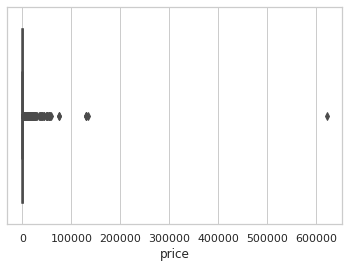

In [145]:
#Checking range of price
ax = sns.boxplot(x=df['price'])

We can see that we have some outliers. Let's remove them. 

In [146]:
#Setting a limit of 5000
df[df['price']>5000].shape[0]

315

We have 315 rows over 5000 in price. Let's remove them.

In [147]:
df = df[df['price']<5000]

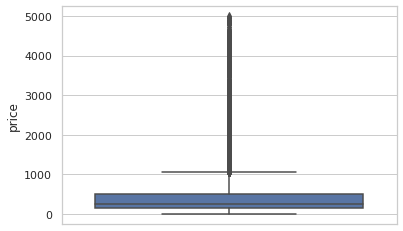

In [148]:
#Checking new range of price
ax = sns.boxplot(y=df['price'])

In [149]:
#Creating bath numbers column from bathroom_text
df['bath_num'] = df.bathrooms_text.str.extract(r'(\d+[.\d]*)')

df['bath_num'] = df['bath_num'].astype(float)

df['bath_num'].head(3)

0    1.0
1    1.0
2    1.0
Name: bath_num, dtype: float64

In [150]:
#Droppping bath_num NAs
df = df[df['bath_num'].notna()]

In [151]:
#Turning float to int for bath_num values
df['bath_num'] = df['bath_num'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [152]:
#Checking column bath_num
df['bath_num'].value_counts()

1     14482
2      5920
3      1750
4       460
5       166
6        93
0        67
7        49
8        21
11        3
9         3
20        3
15        2
10        2
30        1
12        1
Name: bath_num, dtype: int64

In [153]:
#Dropping bathrooms_text column we do not need anymore
df.drop(['bathrooms_text'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [154]:
#Checking ammenities column
df['amenities']

0        ["Hangers", "Dishes and silverware", "Iron", "...
1        ["Clothing storage: wardrobe", "Dining table",...
2        ["Kitchen", "Cable TV", "Hangers", "Iron", "De...
3        ["Hangers", "Dishes and silverware", "Iron", "...
4        ["Hangers", "Dishes and silverware", "Iron", "...
                               ...                        
23407    ["Washer", "Kitchen", "Cable TV", "Hangers", "...
23408    ["Washer", "Private entrance", "Kitchen", "Han...
23409    ["Conditioner", "Dining table", "Hangers", "Mi...
23410    ["Kitchen", "Hangers", "Long term stays allowe...
23411    ["Dining table", "Wifi \u2013 120 Mbps", "Hang...
Name: amenities, Length: 23023, dtype: object

In [155]:
# Handle amenities - Explore most common amenities
amenities = []
for index, row in df.iterrows():
    row['amenities']= row['amenities'].replace('[', '')
    row['amenities']=row['amenities'].replace(']', '')
    row['amenities']=row['amenities'].replace('"', '')
    my_list= row['amenities'].split(',')
    for n in my_list:
        amenities.append(n)

amenities_count= Counter(amenities)
amenities_count.most_common()

[(' Wifi', 20206),
 (' Long term stays allowed', 19571),
 (' Essentials', 19347),
 (' Kitchen', 18951),
 (' Air conditioning', 18001),
 (' Iron', 15159),
 (' Elevator', 14283),
 (' Hot water', 13711),
 (' Dedicated workspace', 12628),
 (' TV', 11179),
 (' Dishes and silverware', 11119),
 (' Cooking basics', 10224),
 (' Hangers', 10095),
 (' Hair dryer', 9894),
 (' Refrigerator', 9893),
 (' Microwave', 9675),
 (' Bed linens', 9444),
 (' Coffee maker', 8651),
 (' Free parking on premises', 8394),
 (' Cable TV', 8255),
 ('Washer', 8060),
 (' Stove', 8004),
 (' TV with standard cable', 7939),
 (' Oven', 7472),
 (' Shampoo', 5911),
 (' Washer', 5871),
 (' Extra pillows and blankets', 5837),
 ('Hangers', 5832),
 (' Fire extinguisher', 5814),
 (' Pool', 5332),
 (' Luggage dropoff allowed', 5115),
 (' Host greets you', 4504),
 (' Free street parking', 4434),
 (' Room-darkening shades', 4032),
 (' Gym', 3856),
 (' Private entrance', 3797),
 (' Patio or balcony', 3649),
 (' First aid kit', 3585)

###Let's keep top 17 values 

(' Wifi', 20528),
 (' Long term stays allowed', 19883),
 (' Essentials', 19623),
 (' Kitchen', 19244),
 (' Air conditioning', 18328),
 (' Iron', 15369),
 (' Elevator', 14466),
 (' Hot water', 13821),
 (' Dedicated workspace', 12804),
 (' TV', 11351),
 (' Dishes and silverware', 11182),
 (' Cooking basics', 10282),
 (' Hangers', 10225),
 (' Hair dryer', 10072),
 (' Refrigerator', 9999),
 (' Microwave', 9753),
 (' Free parking on premises', 8634),
 

In [156]:
amenities_new_cols =['amenities_Wifi|Wifi','amenities_Long term stays allowed|Long term stays allowed',
                     'amenities_Essentials|Essentials','amenities_Kitchen|Kitchen',
                     'amenities_Air conditioning|Air conditioning','amenities_Iron|Iron','amenities_Elevator|Elevator',
                     'amenities_Hot water|Hot water','amenities_Dedicated workspace|Dedicated workspace','amenities_TV|TV',
                     'amenities_Dishes and silverware|Dishes and silverware',
                     'amenities_Cooking basics|Cooking basics','amenities_Hangers|Hangers', 
                     'amenities_Hair dryer|Hair dryer', 'amenities_Refrigerator|Refrigerator',
                     'amenities_Microwave|Microwave', 'amenities_Free parking on premises|Free parking on premises',]

for c in amenities_new_cols:
    c_col, c_desc= c.split('|')
    df[c_col]= df['amenities'].apply(lambda x: 1 if c_desc in x else 0)

In [157]:
df.head(3)

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bath_num,amenities_Wifi,amenities_Long term stays allowed,amenities_Essentials,amenities_Kitchen,amenities_Air conditioning,amenities_Iron,amenities_Elevator,amenities_Hot water,amenities_Dedicated workspace,amenities_TV,amenities_Dishes and silverware,amenities_Cooking basics,amenities_Hangers,amenities_Hair dryer,amenities_Refrigerator,amenities_Microwave,amenities_Free parking on premises
0,17878,within an hour,100.0,98.000000,f,t,t,Copacabana,-22.96599,-43.17940,Entire condominium (condo),Entire home/apt,5,2.0,2.0,"[""Hangers"", ""Dishes and silverware"", ""Iron"", ""...",350.0,16,46,69,314,265,12,0,2011-03-30,2021-05-21,4.68,4.78,4.63,4.82,4.9,4.76,4.65,2.07,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
1,24480,within a day,50.0,72.932538,f,t,t,Ipanema,-22.98405,-43.20189,Entire rental unit,Entire home/apt,2,1.0,1.0,"[""Clothing storage: wardrobe"", ""Dining table"",...",297.0,0,0,0,30,85,0,0,2013-08-20,2017-04-22,4.73,4.83,4.78,4.90,4.9,4.97,4.58,0.86,1,1,1,1,0,1,1,0,1,1,1,1,0,1,1,1,1,0
2,25026,within a day,50.0,36.000000,f,t,t,Copacabana,-22.97735,-43.19105,Entire rental unit,Entire home/apt,2,1.0,2.0,"[""Kitchen"", ""Cable TV"", ""Hangers"", ""Iron"", ""De...",160.0,0,0,27,266,238,0,0,2011-03-18,2019-04-27,4.68,4.65,4.76,4.77,4.9,4.81,4.56,1.86,1,1,1,1,1,1,1,1,0,1,1,0,0,1,1,0,0,0


In [158]:
#Dropp amenities column since we will not use it anymore
df.drop('amenities', axis=1, inplace=True)

In [159]:
#Checking property_type colum
df.property_type.value_counts()

Entire rental unit                   12939
Private room in rental unit           3414
Entire condominium (condo)            1399
Private room in residential home      1052
Entire residential home                919
                                     ...  
Private room in tent                     1
Entire vacation home                     1
Shared room in bungalow                  1
Entire dorm                              1
Shared room in serviced apartment        1
Name: property_type, Length: 85, dtype: int64

Since we have too many different values in this column, and "room_type" is standardized and easier to work with, we are going to drop property_type.

In [160]:
df.drop('property_type', axis=1, inplace=True)

In [161]:
#Cleaning neighbourhood names
df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].str.lower()
df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].str.strip()

df.neighbourhood_cleansed.value_counts()

copacabana                  6629
barra da tijuca             2321
ipanema                     2272
jacarepaguá                 1114
recreio dos bandeirantes    1047
                            ... 
vista alegre                   1
maré                           1
deodoro                        1
jacarezinho                    1
ribeira                        1
Name: neighbourhood_cleansed, Length: 153, dtype: int64

In [162]:
#Checking the remaining columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23023 entries, 0 to 23411
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  23023 non-null  int64  
 1   host_response_time                  23023 non-null  object 
 2   host_response_rate                  23023 non-null  float64
 3   host_acceptance_rate                23023 non-null  float64
 4   host_is_superhost                   23023 non-null  object 
 5   host_has_profile_pic                23023 non-null  object 
 6   host_identity_verified              23023 non-null  object 
 7   neighbourhood_cleansed              23023 non-null  object 
 8   latitude                            23023 non-null  float64
 9   longitude                           23023 non-null  float64
 10  room_type                           23023 non-null  object 
 11  accommodates                        23023

#EDA cleaned listing Dataset

In [163]:
#Checking the numeric variables
df.describe()

,id,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,bedrooms,beds,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bath_num,amenities_Wifi,amenities_Long term stays allowed,amenities_Essentials,amenities_Kitchen,amenities_Air conditioning,amenities_Iron,amenities_Elevator,amenities_Hot water,amenities_Dedicated workspace,amenities_TV,amenities_Dishes and silverware,amenities_Cooking basics,amenities_Hangers,amenities_Hair dryer,amenities_Refrigerator,amenities_Microwave,amenities_Free parking on premises
count,2.302300e+04,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000,23023.000000
mean,2.646383e+07,78.147556,73.063684,-22.965716,-43.248120,4.067324,1.627590,2.505668,476.767797,19.521044,42.010555,65.185554,228.376797,14.274856,3.263432,0.346262,4.589894,4.790316,4.679170,4.870524,4.850275,4.849456,4.638263,0.651863,1.542935,0.908700,0.867480,0.840855,0.906224,0.782435,0.661599,0.621639,0.596708,0.569778,0.873040,0.503844,0.444251,0.691786,0.429744,0.429744,0.420753,0.365287
std,1.664576e+07,28.627760,27.430994,0.035394,0.096763,2.398270,0.999847,2.206885,599.861768,11.838497,22.551211,32.289616,130.216055,33.476932,8.028204,0.912457,0.756560,0.373514,0.436360,0.315259,0.334142,0.300743,0.403576,0.733542,0.959734,0.288042,0.339062,0.365819,0.291523,0.412599,0.473176,0.484989,0.490569,0.495118,0.332935,0.499996,0.496893,0.461765,0.495050,0.495050,0.493691,0.481521
min,1.787800e+04,0.000000,0.000000,-23.072620,-43.698890,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.249427e+07,78.105366,72.932538,-22.984560,-43.302810,2.000000,1.000000,1.000000,150.000000,8.000000,26.000000,47.000000,90.000000,0.000000,0.000000,0.000000,4.588884,4.790155,4.679409,4.870508,4.850292,4.849142,4.638280,0.160000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.652959e+07,78.105366,72.932538,-22.971820,-43.195920,4.000000,1.000000,2.000000,262.000000,26.000000,55.000000,84.000000,262.000000,2.000000,0.000000,0.000000,4.600000,4.790155,4.679409,4.870508,4.850292,4.849142,4.638280,0.649966,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,4.197019e+07,100.000000,98.000000,-22.950655,-43.186055,5.000000,2.000000,3.000000,514.000000,30.000000,59.000000,89.000000,362.000000,11.000000,2.000000,0.000000,4.980000,5.000000,4.950000,5.000000,5.000000,5.000000,4.830000,0.649966,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,5.249041e+07,100.000000,100.000000,-22.749690,-43.104400,16.000000,30.000000,91.000000,4992.000000,30.000000,60.000000,90.000000,365.000000,486.000000,239.000000,17.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,25.520000,30.000000,1.000

###Checking Price column

Text(0.5, 1.0, 'Price range distribution')

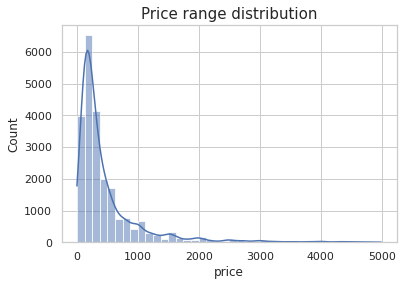

In [164]:
#Price histogram
sns.histplot(data=df, x="price", bins=40, kde=True)
plt.title('Price range distribution', fontdict={'fontsize': 15})

###Checking the host Columns


Text(0.5, 1.0, 'Count of hosts by time to response')

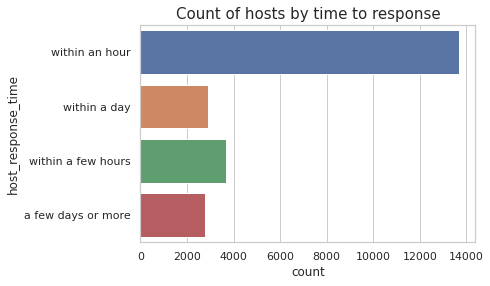

In [165]:
#Plotting the quantity of hosts according to time to response groups
sns.set_theme(style="whitegrid")
sns.countplot(y='host_response_time', data=df)
plt.title('Count of hosts by time to response', fontdict={'fontsize': 15})

From above we can see that "within an hour" is the most frequent group. It is important to note that due to the way we filled in the missing values (with mode) this number is higher than it could be. Anyway, even if we haven't done that this group would still be the most frequent.  

Text(0.5, 1.0, 'Host response rate distribution (%)')

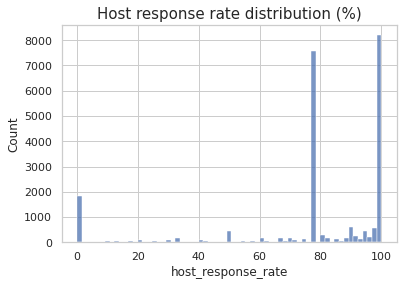

In [166]:
#Host response rate histogram
sns.histplot(data=df, x="host_response_rate")
plt.title('Host response rate distribution (%)', fontdict={'fontsize': 15})

Text(0.5, 1.0, 'Hosts acceptance rate distribution (%)')

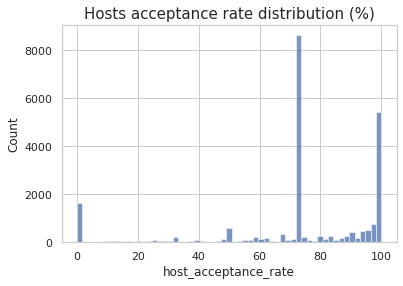

In [167]:
#Host acceptance rate histogram
sns.histplot(data=df, x="host_acceptance_rate")
plt.title('Hosts acceptance rate distribution (%)', fontdict={'fontsize': 15})

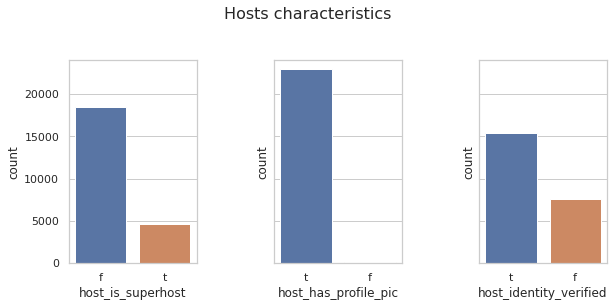

In [168]:
fig, ax =plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(10, 5))
fig.suptitle('Hosts characteristics', fontsize=16)

sns.countplot(df['host_is_superhost'], ax=ax[0])
sns.countplot(df['host_has_profile_pic'], ax=ax[1])
sns.countplot(df['host_identity_verified'], ax=ax[2])

fig.show()                  
plt.tight_layout(pad=5, w_pad=5)

From the graphs above we can see that we have less superhosts than normal ones, most of the hosts has profile picture (can suggest more credibility) in their register and most of them have the id verified.  

Text(0.5, 1.0, 'Mean price by superhost or not')

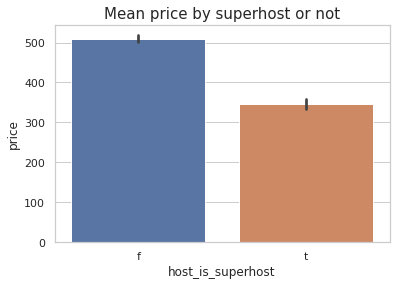

In [169]:
sns.barplot(data=df, x='host_is_superhost', y='price')
plt.title('Mean price by superhost or not', fontdict={'fontsize': 15})

From above we note that being a superhost is no guarantee of higher prices.

###Bedrooms and accommodates

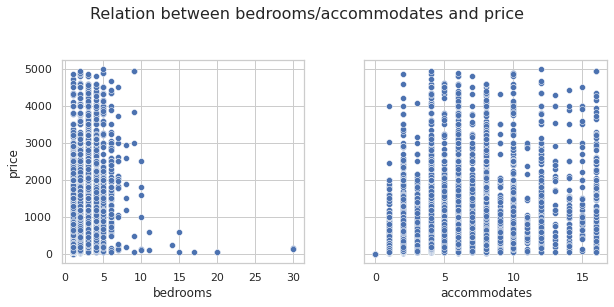

In [170]:
fig, ax =plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
fig.suptitle('Relation between bedrooms/accommodates and price', fontsize=16)

sns.scatterplot(data=df, x='bedrooms', y='price', ax=ax[0])
sns.scatterplot(data=df, x='accommodates', y='price', ax=ax[1])

fig.show()                  
plt.tight_layout(pad=5, w_pad=5)

Checking the charts above we cannot see a clear relation between bedrooms/accommodates and increase or decrease in prices. 

###Checking neighbourhood information

In [171]:
#Selecting neighbourhoods with more than 50 samples 
nei_over_50 = list(df.neighbourhood_cleansed.value_counts()[df.neighbourhood_cleansed.value_counts()>50].index)

In [172]:
#getting the mean price for each neighbourhood 
df_plot_nei = df.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False).reset_index()

In [173]:
#Filtering by neighbourhood with more than 50 samples
df_plot_nei = df_plot_nei[df_plot_nei['neighbourhood_cleansed'].isin(nei_over_50)]

Text(0.5, 1.0, 'Top neighborhood in price (mean)')

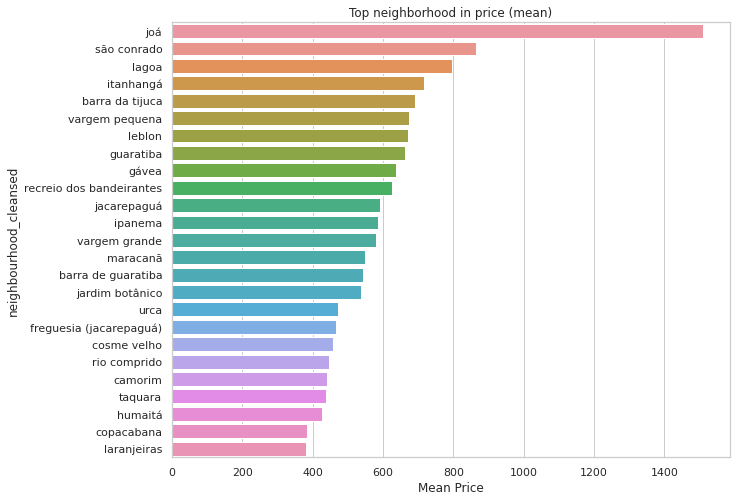

In [177]:
#plotting top n neighborhoods in price (only over 50 samples included)

n=25

df_plot_nei_n = df_plot_nei.head(n)

fig, ax =plt.subplots(figsize=(10, 8))
ax = sns.barplot(x='price', y='neighbourhood_cleansed', data=df_plot_nei_n)
ax.set_xlabel('Mean Price')
ax.set_title('Top neighborhood in price (mean)')

In [178]:
#getting the total offers for each neighbourhood 
df_plot_nei_offers = df.groupby('neighbourhood_cleansed')['price'].count().sort_values(ascending=False).reset_index()

#Filtering by neighbourhood with more than 50 samples
df_plot_nei_offers = df_plot_nei_offers[df_plot_nei_offers['neighbourhood_cleansed'].isin(nei_over_50)]

df_plot_nei_offers.head(3)

,neighbourhood_cleansed,price
0,copacabana,6629
1,barra da tijuca,2321
2,ipanema,2272


Text(0.5, 1.0, 'Top neighbourhood in Offers (total)')

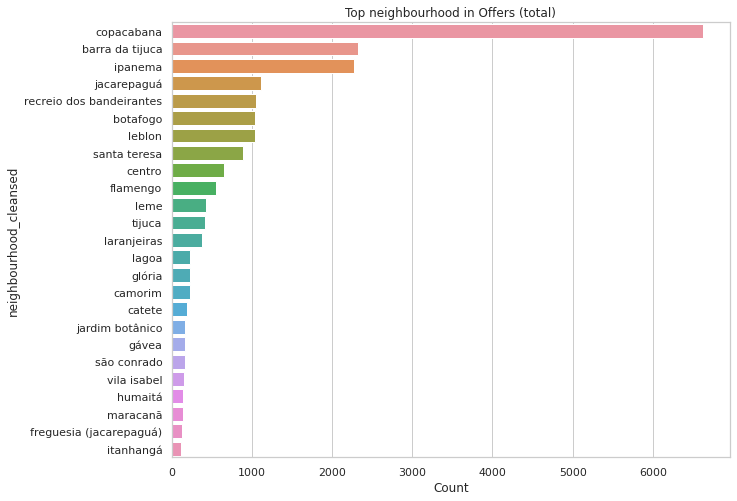

In [180]:
#plotting top n neighbourhoods in offers (only over 50 samples included)

n=25

df_plot_nei_offers_n = df_plot_nei_offers.head(n)

fig, ax =plt.subplots(figsize=(10, 8))
ax = sns.barplot(x='price', y='neighbourhood_cleansed', data=df_plot_nei_offers_n)
ax.set_xlabel('Count')
ax.set_title('Top neighbourhood in Offers (total)')

From the two last charts above we see that the neighbourhood affects the price, and most of the offers available is contained in 10 to 15 neighbourhoods. A highlight to Copacabana which has more than twice the total offers of the second place, Barra da Tijuca.   

###Room type analysis

Text(0.5, 1.0, 'Count of room type')

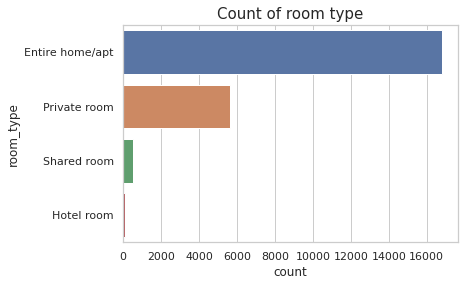

In [181]:
sns.countplot(y='room_type', data=df)
plt.title('Count of room type', fontdict={'fontsize': 15})

Text(0.5, 1.0, 'Mean price by room type')

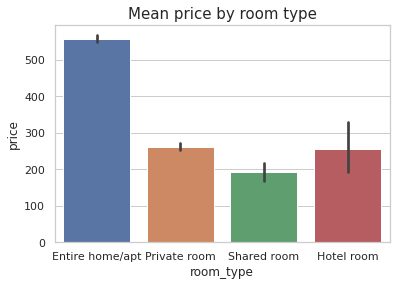

In [182]:
sns.barplot(data=df, x='room_type', y='price')
plt.title('Mean price by room type', fontdict={'fontsize': 15})

As expected, entire home is more expensive than the others.

###Review scores rating

Text(0.5, 1.0, 'Review scores rating distribution')

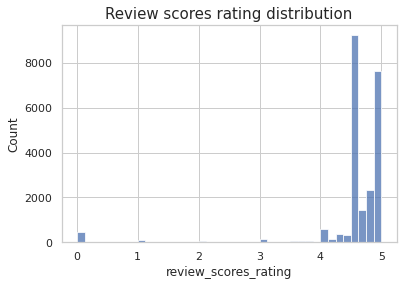

In [183]:
#Review scores rating histogram
sns.histplot(data=df, x="review_scores_rating", bins=40)
plt.title('Review scores rating distribution', fontdict={'fontsize': 15})

#Modelling

In [184]:
df.head(2)

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bath_num,amenities_Wifi,amenities_Long term stays allowed,amenities_Essentials,amenities_Kitchen,amenities_Air conditioning,amenities_Iron,amenities_Elevator,amenities_Hot water,amenities_Dedicated workspace,amenities_TV,amenities_Dishes and silverware,amenities_Cooking basics,amenities_Hangers,amenities_Hair dryer,amenities_Refrigerator,amenities_Microwave,amenities_Free parking on premises
0,17878,within an hour,100.0,98.000000,f,t,t,copacabana,-22.96599,-43.17940,Entire home/apt,5,2.0,2.0,350.0,16,46,69,314,265,12,0,2011-03-30,2021-05-21,4.68,4.78,4.63,4.82,4.9,4.76,4.65,2.07,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
1,24480,within a day,50.0,72.932538,f,t,t,ipanema,-22.98405,-43.20189,Entire home/apt,2,1.0,1.0,297.0,0,0,0,30,85,0,0,2013-08-20,2017-04-22,4.73,4.83,4.78,4.90,4.9,4.97,4.58,0.86,1,1,1,1,0,1,1,0,1,1,1,1,0,1,1,1,1,0


In [185]:
dict_av

{'f': 0, 't': 1}

In [186]:
for column in ['host_is_superhost',	'host_has_profile_pic',	'host_identity_verified']:
  df[column] = df[column].map(dict_av)

In [187]:
#Extracting year and month from date column
df['year_first_review'] = pd.DatetimeIndex(df['first_review']).year
df['year_last_review'] = pd.DatetimeIndex(df['last_review']).year

In [188]:
df.columns

Index(['id', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bedrooms', 'beds', 'price',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'bath_num',
       'amenities_Wifi', 'amenities_Long term stays allowed',
       'amenities_Essentials', 'amenities_Kitchen',
       'amenities_Air conditioning', 'amenities_Iron', 'amenities_Elevator',
       'amenities_Hot water', 'amenities_Dedicated workspace', 'amenities_TV',
  

In [189]:
#Dropping some columns we won't use in our model
df.drop(['id', 'first_review', 'last_review'], axis=1, inplace=True)

**Keeping only the rows which have a neighbourhood that is present more than 50 times in the dataset.**

In [190]:
#Keeping only the rows which have a neighbourhood that is present more than 50 times in the dataset
df = df[df.neighbourhood_cleansed.isin(nei_over_50)]

In [191]:
cat_cols = ['host_response_time', 'neighbourhood_cleansed', 'room_type']

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue

    return df

In [192]:
df_model = create_dummy_df(df, cat_cols, dummy_na=False)

df_model.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bath_num,amenities_Wifi,amenities_Long term stays allowed,amenities_Essentials,amenities_Kitchen,amenities_Air conditioning,amenities_Iron,amenities_Elevator,amenities_Hot water,amenities_Dedicated workspace,amenities_TV,amenities_Dishes and silverware,amenities_Cooking basics,amenities_Hangers,...,neighbourhood_cleansed_botafogo,neighbourhood_cleansed_camorim,neighbourhood_cleansed_campo grande,neighbourhood_cleansed_catete,neighbourhood_cleansed_centro,neighbourhood_cleansed_copacabana,neighbourhood_cleansed_cosme velho,neighbourhood_cleansed_curicica,neighbourhood_cleansed_estácio,neighbourhood_cleansed_flamengo,neighbourhood_cleansed_freguesia (jacarepaguá),neighbourhood_cleansed_glória,neighbourhood_cleansed_guaratiba,neighbourhood_cleansed_gávea,neighbourhood_cleansed_humaitá,neighbourhood_cleansed_ipanema,neighbourhood_cleansed_itanhangá,neighbourhood_cleansed_jacarepaguá,neighbourhood_cleansed_jardim botânico,neighbourhood_cleansed_joá,neighbourhood_cleansed_lagoa,neighbourhood_cleansed_laranjeiras,neighbourhood_cleansed_leblon,neighbourhood_cleansed_leme,neighbourhood_cleansed_maracanã,neighbourhood_cleansed_recreio dos bandeirantes,neighbourhood_cleansed_rio comprido,neighbourhood_cleansed_santa teresa,neighbourhood_cleansed_são conrado,neighbourhood_cleansed_são cristóvão,neighbourhood_cleansed_taquara,neighbourhood_cleansed_tijuca,neighbourhood_cleansed_urca,neighbourhood_cleansed_vargem grande,neighbourhood_cleansed_vargem pequena,neighbourhood_cleansed_vidigal,neighbourhood_cleansed_vila isabel,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,100.0,98.000000,0,1,1,-22.96599,-43.17940,5,2.0,2.0,350.0,16,46,69,314,265,12,0,4.68,4.78,4.63,4.82,4.90,4.76,4.65,2.07,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,50.0,72.932538,0,1,1,-22.98405,-43.20189,2,1.0,1.0,297.0,0,0,0,30,85,0,0,4.73,4.83,4.78,4.90,4.90,4.97,4.58,0.86,1,1,1,1,0,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,50.0,36.000000,0,1,1,-22.97735,-43.19105,2,1.0,2.0,160.0,0,0,27,266,238,0,0,4.68,4.65,4.76,4.77,4.90,4.81,4.56,1.86,1,1,1,1,1,1,1,1,0,1,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100.0,72.932538,1,1,1,-22.98839,-43.19232,2,1.0,1.0,271.0,0,0,0,151,181,0,0,4.72,4.85,4.63,4.85,4.88,4.90,4.65,1.92,1,1,1,1,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100.0,97.000000,1,1,1,-22.98107,-43.19136,2,1.0,1.0,121.0,0,4,7,30,371,35,3,4.90,4.93,4.94,4.96,4.94,4.94,4.87,3.05,1,1,0,1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [193]:
#Split into explanatory and response variables
X = df_model.drop('price', axis=1)
y = df_model['price']

In [194]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [195]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15318, 89) (15318,)
(6565, 89) (6565,)


###Linear regression model

In [196]:
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [197]:
y_train_preds = lm_model.predict(X_train) #predict on train data
y_test_preds = lm_model.predict(X_test)  #Predict on test data

In [198]:
print('The train R2 score is: {}, and the test R2 score is {}'.format(r2_score(y_train, y_train_preds), r2_score(y_test, y_test_preds)))

The train R2 score is: 0.4091679151415173, and the test R2 score is 0.4244736105746165


###Random Forest regressor

In [199]:
clf = RandomForestRegressor(max_depth=20, n_estimators=100)

In [200]:
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [201]:
y_train_preds = clf.predict(X_train)
y_test_preds = clf.predict(X_test)

In [202]:
print('The train R2 score is: {}, and the test R2 score is {}'.format(r2_score(y_train, y_train_preds), r2_score(y_test, y_test_preds)))

The train R2 score is: 0.9192443489379294, and the test R2 score is 0.4878837420036757


###SVR Model

In [207]:
SVR = SVR('linear', C=1.0, epsilon=0.2)

In [208]:
SVR.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [209]:
y_train_preds = SVR.predict(X_train)
y_test_preds = SVR.predict(X_test)

In [210]:
train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test, y_test_preds)

In [211]:
print('The train R2 score is: {}, and the test R2 score is {}'.format(train_score, test_score))

The train R2 score is: 0.3381551612996436, and the test R2 score is 0.3580549998382774


###XGboost model

In [203]:
#train XGBoost model
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.1, subsample=0.75,
                            max_depth=7)

In [216]:
#train XGBoost model
xgb = xgboost.XGBRegressor(n_estimators=50, learning_rate=0.05, subsample=0.75,
                            max_depth=7)

In [217]:
xgb.fit(X_train,y_train)

[23:06:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [218]:
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

In [219]:
print('The train R2 score is: {}, and the test R2 score is {}'.format(r2_score(y_train, y_train_preds), r2_score(y_test, y_test_preds)))

The train R2 score is: 0.6424865586477666, and the test R2 score is 0.5095390950617028


#Refinement

In [228]:
params = {
    'xgb__n_estimators': [100, 150],
    'xgb__learning_rate': [0.08, 0.1]
}

In [229]:
cv = GridSearchCV(xgb, param_grid=params, scoring='r2', verbose=3)

In [230]:
cv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] xgb__learning_rate=0.08, xgb__n_estimators=100 ..................
[23:30:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  xgb__learning_rate=0.08, xgb__n_estimators=100, score=0.514, total=   4.0s
[CV] xgb__learning_rate=0.08, xgb__n_estimators=100 ..................
[23:30:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV]  xgb__learning_rate=0.08, xgb__n_estimators=100, score=0.501, total=   3.9s
[CV] xgb__learning_rate=0.08, xgb__n_estimators=100 ..................
[23:30:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


[CV]  xgb__learning_rate=0.08, xgb__n_estimators=100, score=0.499, total=   3.9s
[CV] xgb__learning_rate=0.08, xgb__n_estimators=100 ..................
[23:30:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  xgb__learning_rate=0.08, xgb__n_estimators=100, score=0.495, total=   3.9s
[CV] xgb__learning_rate=0.08, xgb__n_estimators=100 ..................
[23:30:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  xgb__learning_rate=0.08, xgb__n_estimators=100, score=0.491, total=   3.9s
[CV] xgb__learning_rate=0.08, xgb__n_estimators=150 ..................
[23:30:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  xgb__learning_rate=0.08, xgb__n_estimators=150, score=0.514, total=   4.0s
[CV] xgb__learning_rate=0.08, xgb__n_estimators=150 ..................
[23:31:01] 

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=7,
                                    min_child_weight=1, missing=None,
                                    n_estimators=50, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=0.75, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'xgb__learning_rate': [0.08, 0.1],
                         'xgb__n_estimators': [100, 150]},
       

In [231]:
#Checking the best params
cv.best_params_

{'xgb__learning_rate': 0.08, 'xgb__n_estimators': 100}

In [240]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, subsample=0.75,
                            max_depth=7)

In [241]:
xgb.fit(X_train,y_train)

[23:36:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [242]:
#Predict
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

In [243]:
print('The train R2 score is: {}, and the test R2 score is {}'.format(r2_score(y_train, y_train_preds), r2_score(y_test, y_test_preds)))

The train R2 score is: 0.7760108271808667, and the test R2 score is 0.5477201923097432
